In [1]:
# Basic imports for the entire Kernel
import numpy as np
import pandas as pd
# imports for loading data
import pydicom
from glob import glob
# import mask function
import sys
sys.path.insert(0, '../input/siimacr')
from mask_functions import rle2mask, mask2rle
# plotting function
from matplotlib import pyplot as plt
import os

In [2]:
#os.listdir("../input/siim-acr-pneumothorax-segmentation-data/pneumothorax")

In [3]:
rle_df=pd.read_csv("../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/train-rle.csv")
rle_df.columns=['ImageID','EncodedPixels']
rle_df.head()

,ImageID,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [4]:
train_paths=sorted(glob("../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-train/*/*/*.dcm"))
test_paths=sorted(glob("../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-test/*/*/*.dcm"))

In [5]:
def dicom_to_dict(dicom_data, file_path, rles_df, encoded_pixels=True):
    """Parse DICOM dataset and returns a dictonary with relevant fields.

    Args:
        dicom_data (dicom): chest x-ray data in dicom format.
        file_path (str): file path of the dicom data.
        rles_df (pandas.core.frame.DataFrame): Pandas dataframe of the RLE.
        encoded_pixels (bool): if True we will search for annotation.
        
    Returns:
        dict: contains metadata of relevant fields.
    """
    
    data = {}
    
    data['patient_name']=str(dicom_data.PatientName)
    data['patient_id']=dicom_data.PatientID
    data['patient_age']=int(dicom_data.PatientAge)
    data['patient_sex']=dicom_data.PatientSex
    data['pixel_spacing']=list(dicom_data.PixelSpacing)
    data['file_path']=file_path
    data['id'] = dicom_data.SOPInstanceUID
    
    if encoded_pixels:
        encoded_pixels_list = rle_df[rle_df['ImageID']==data['id']]['EncodedPixels'].values
        pneumothorax = False
        for encoded_pixels in encoded_pixels_list:
            if encoded_pixels != ' -1':
                pneumothorax = True
        
        data['encoded_pixels_list'] = encoded_pixels_list
        data['has_pneumothorax'] = pneumothorax
        data['encoded_pixels_count'] = len(encoded_pixels_list)
        
    return data

In [6]:
train_metadata_list=[]
for file_path in train_paths:
    dicom_data=pydicom.read_file(file_path)
    train_metadata=dicom_to_dict(dicom_data,file_path,rle_df)
    train_metadata_list.append(train_metadata)
train_metadata_df=pd.DataFrame(train_metadata_list)

In [7]:
test_metadata_list=[]
for file_path in test_paths:
    dicom_data=pydicom.read_file(file_path)
    test_metadata=dicom_to_dict(dicom_data,file_path,rle_df,encoded_pixels=False)
    test_metadata_list.append(test_metadata)
test_metadata_df=pd.DataFrame(test_metadata_list)

In [8]:
img_size=256
batch_size=32
k_size=3
val_size=0.20
no_pneumo_drop=0

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPool2D,UpSampling2D,Concatenate,Add
from sklearn.model_selection import train_test_split
import cv2

In [10]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,file_path_list,labels,batch_size=32,img_size=256,channels=1,shuffle=True):
        self.file_path_list=file_path_list
        self.labels=labels
        self.batch_size=batch_size
        self.img_size=img_size
        self.channels=channels
        self.shuffle=shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.file_path_list))/self.batch_size)
    
    def __getitem__(self,index):
        indexes=self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        file_path_list_temp=[self.file_path_list[k] for k in indexes]
        X,y=self.__data_generation(file_path_list_temp)
        return X,y
    
    def on_epoch_end(self):
        self.indexes=np.arange(len(self.file_path_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self,file_path_list_temp):
        X=np.empty((self.batch_size,self.img_size,self.img_size,self.channels))
        y=np.empty((self.batch_size,self.img_size,self.img_size,self.channels))
        for idx,file_path in enumerate(file_path_list_temp):
            id=file_path.split('/')[-1][:-4]
            rle=self.labels.get(id)
            image=pydicom.read_file(file_path).pixel_array
            image_resized=cv2.resize(image,(self.img_size,self.img_size))
            image_resized=np.array(image_resized,dtype=np.float64)
            X[idx,]=np.expand_dims(image_resized,axis=2)
            if rle is None:
                mask=np.zeros((1024,1024))
            else:
                if len(rle)==1:
                    mask=rle2mask(rle[0],1024,1024).T
                else:
                    mask=np.zeros((1024,1024))
                    for x in rle:
                        mask=mask+rle2mask(x,1024,1024).T
            mask_resized=cv2.resize(mask,(self.img_size,self.img_size))
            y[idx,]=np.expand_dims(mask_resized,axis=2)
        X=X/255
        y=y/255
        return X,y

In [11]:
masks={}
for index,row in train_metadata_df[train_metadata_df['has_pneumothorax']==1].iterrows():
    masks[row['id']]=list(row['encoded_pixels_list'])

In [12]:
bad_data=train_metadata_df[train_metadata_df['encoded_pixels_count']==0].index
new_train_metadata_df=train_metadata_df.drop(bad_data)

In [13]:
bad_data

Int64Index([  252,   396,   445,   654,   743,  1208,  1328,  1703,  1713,
             1725,  1733,  2252,  3690,  3731,  3957,  4984,  5660,  5765,
             5887,  6141,  6199,  6637,  6897,  7446,  7865,  8003,  8037,
             8431,  8516,  8892,  9153,  9257,  9670,  9837,  9937, 10146,
            10434],
           dtype='int64')

In [14]:
drop_data=new_train_metadata_df[new_train_metadata_df['has_pneumothorax']==False].sample(no_pneumo_drop).index
new_train_metadata_df=new_train_metadata_df.drop(drop_data)

In [15]:
X_train,X_test,y_train,y_test=train_test_split(new_train_metadata_df.index,new_train_metadata_df['has_pneumothorax'].values,test_size=val_size)
X_train=new_train_metadata_df.loc[X_train]['file_path'].values
X_test=new_train_metadata_df.loc[X_test]['file_path'].values

In [16]:
params={'img_size':img_size,'batch_size':batch_size,'channels':1,'shuffle':True}
training_generator=DataGenerator(X_train,masks,**params)
validation_generator=DataGenerator(X_test,masks,**params)

In [17]:
x,y=training_generator.__getitem__(0)
print(x.shape,y.shape)

(32, 256, 256, 1) (32, 256, 256, 1)


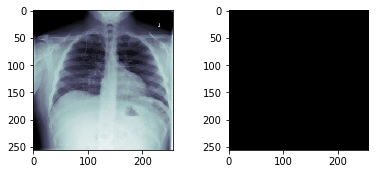

In [18]:
fig=plt.figure()
fig.subplots_adjust(hspace=0.4,wspace=0.4)
ax=fig.add_subplot(1,2,1)
ax.imshow(x[2].reshape(img_size,img_size),cmap=plt.cm.bone)
ax=fig.add_subplot(1,2,2)
ax.imshow(y[2].reshape(img_size,img_size),cmap="gray")

In [19]:
def bn_act(x,act=True):
    x=tf.keras.layers.BatchNormalization()(x)
    if act==True:
        x=tf.keras.layers.Activation('relu')(x)
    return x

In [20]:
def conv_block(x,filters,kernel_size=3,padding='same',strides=1):
    conv=bn_act(x)
    conv=Conv2D(filters,kernel_size,padding=padding,strides=strides)(conv)
    return conv

In [21]:
def stem(x,filters,kernel_size=3,padding='same',strides=1):
    conv=Conv2D(filters,kernel_size,padding=padding,strides=strides)(x)
    conv=conv_block(conv,filters,kernel_size,padding,strides)
    shortcut=Conv2D(filters,kernel_size=1,padding=padding,strides=strides)(x)
    shortcut=bn_act(shortcut,act=False)
    output=Add()([conv,shortcut])
    return output

In [22]:
def residual_block(x,filters,kernel_size=3,padding='same',strides=1):
    res=conv_block(x,filters,kernel_size,padding,strides)
    res=conv_block(res,filters,kernel_size,padding,1)
    shortcut=Conv2D(filters,kernel_size,padding=padding,strides=strides)(x)
    shortcut=bn_act(shortcut,act=False)
    output=Add()([shortcut,res])
    return output

In [23]:
def upsample_concat_block(x,xskip):
    u=UpSampling2D((2,2))(x)
    c=Concatenate()([u,xskip])
    return c

In [24]:
def ResUNet(img_size):
    f=[16,32,64,128,256] * 64
    inputs=Input((img_size,img_size,1))
    
    e0=inputs
    e1=stem(e0,f[0])
    e2=residual_block(e1,f[1],strides=2)
    e3=residual_block(e2,f[2],strides=2)
    e4=residual_block(e3,f[3],strides=2)
    e5=residual_block(e4,f[4],strides=2)

    b0=conv_block(e5,f[4],strides=1)
    b1=conv_block(b0,f[4],strides=1)
    
    u1=upsample_concat_block(b1,e4)
    d1=residual_block(u1,f[4])
    
    u2=upsample_concat_block(d1,e3)
    d2=residual_block(u2,f[3])
    
    u3=upsample_concat_block(d2,e2)
    d3=residual_block(u3,f[2])
    
    u4=upsample_concat_block(d3,e1)
    d4=residual_block(u4,f[1])
    
    outputs=Conv2D(1,(1,1),padding="same",activation="sigmoid")(d4)
    model=Model(inputs,outputs)
    
    return model

In [25]:
smooth=1
def dice_coeff(y_true,y_pred):
    y_true_f=tf.keras.layers.Flatten()(y_true)
    y_pred_f=tf.keras.layers.Flatten()(y_pred)
    intersection=tf.reduce_sum(y_true_f*y_pred_f)
    return(2.*intersection+smooth)/(tf.reduce_sum(y_true_f)+tf.reduce_sum(y_pred_f)+smooth)

def dice_coeff_loss(y_true,y_pred):
    return 1.0-dice_coeff(y_true,y_pred)

In [26]:
model=ResUNet(img_size)
adam=tf.keras.optimizers.Adam(lr=0.01,epsilon=0.1)
model.compile(optimizer=adam,loss=dice_coeff_loss,metrics=[dice_coeff])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [27]:
history=model.fit_generator(generator=training_generator,validation_data=validation_generator,epochs=100)

Epoch 1/100
266/266 [==============================] - 186s 701ms/step - loss: 0.9914 - dice_coeff: 0.0086 - val_loss: 0.9917 - val_dice_coeff: 0.0083
Epoch 2/100
266/266 [==============================] - 174s 655ms/step - loss: 0.9798 - dice_coeff: 0.0202 - val_loss: 0.9700 - val_dice_coeff: 0.0300
Epoch 3/100
266/266 [==============================] - 173s 650ms/step - loss: 0.9016 - dice_coeff: 0.0984 - val_loss: 0.9002 - val_dice_coeff: 0.0998
Epoch 4/100
266/266 [==============================] - 173s 652ms/step - loss: 0.8626 - dice_coeff: 0.1374 - val_loss: 0.8814 - val_dice_coeff: 0.1186
Epoch 5/100
266/266 [==============================] - 173s 650ms/step - loss: 0.8291 - dice_coeff: 0.1709 - val_loss: 0.8700 - val_dice_coeff: 0.1300
Epoch 6/100
266/266 [==============================] - 174s 652ms/step - loss: 0.8059 - dice_coeff: 0.1941 - val_loss: 0.8922 - val_dice_coeff: 0.1078
Epoch 7/100
266/266 [==============================] - 173s 651ms/step - loss: 0.7803 - dice_c

In [28]:
model.save('/kaggle/working/SIIM-ResUNet_100.h5')

In [29]:
def plot_train(img,mask,pred,count):
    fig,ax=plt.subplots(nrows=1,ncols=3,sharey=True,figsize=(15,5))
    ax[0].imshow(img,cmap=plt.cm.bone)
    ax[0].set_title('Chest X-Ray')
    
    ax[1].imshow(mask,cmap=plt.cm.bone)
    ax[1].set_title('Mask')
    
    ax[2].imshow(pred,cmap=plt.cm.bone)
    ax[2].set_title('Predicted')
    
    plt.savefig('/kaggle/working/preds'+str(count)+'.png')
    plt.show()


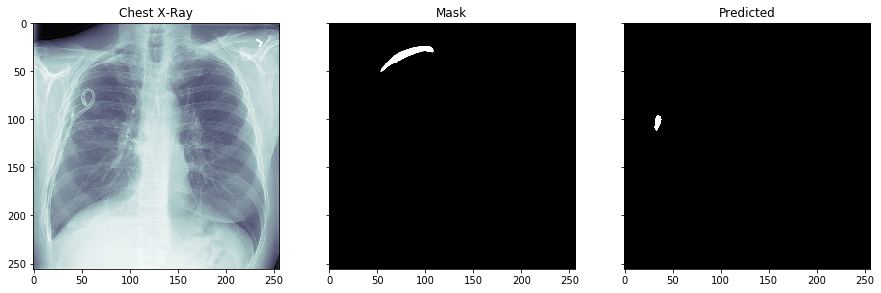

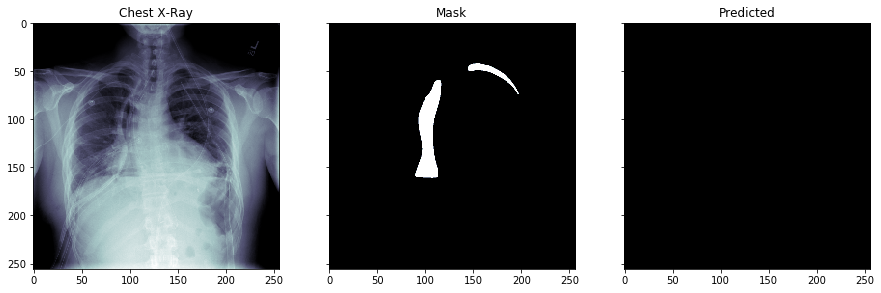

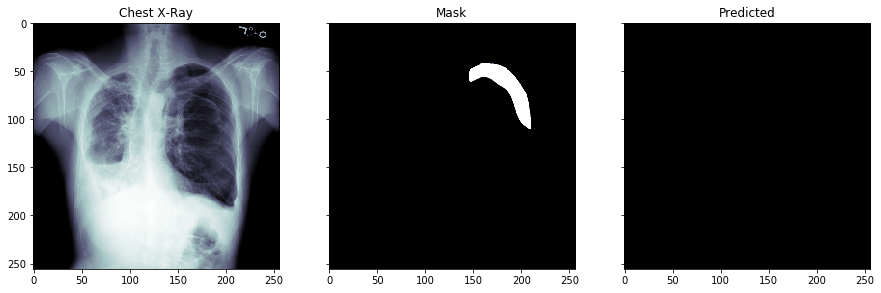

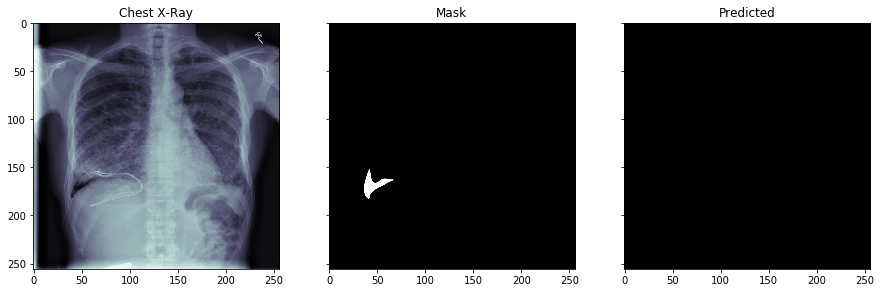

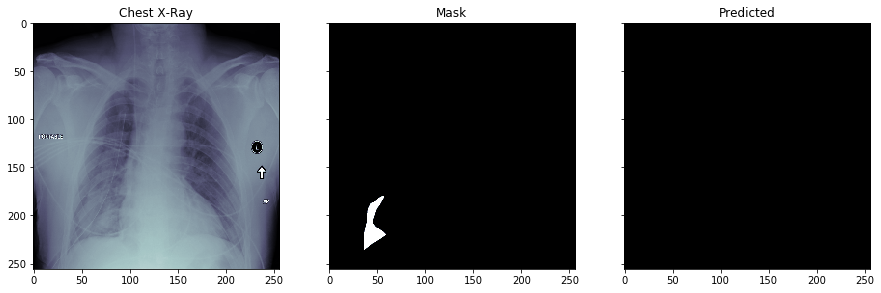

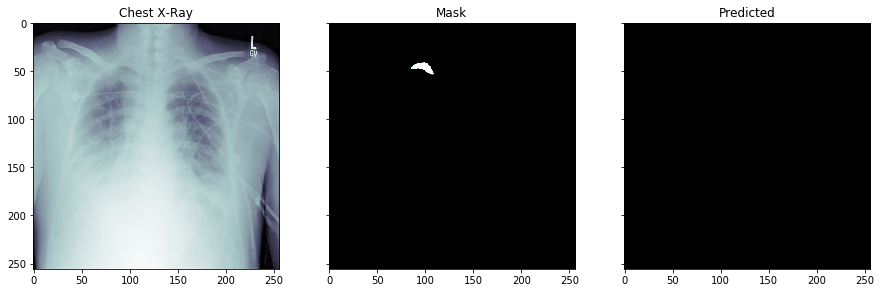

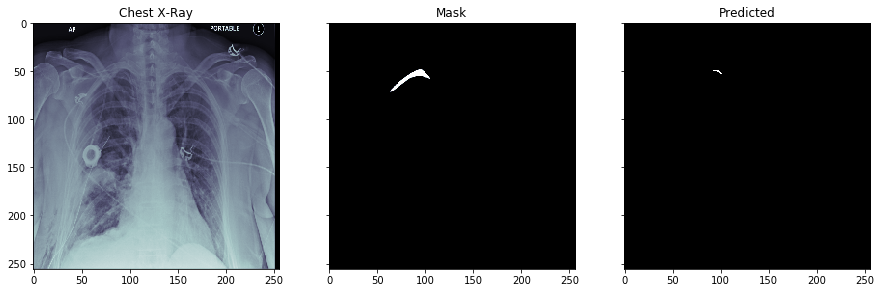

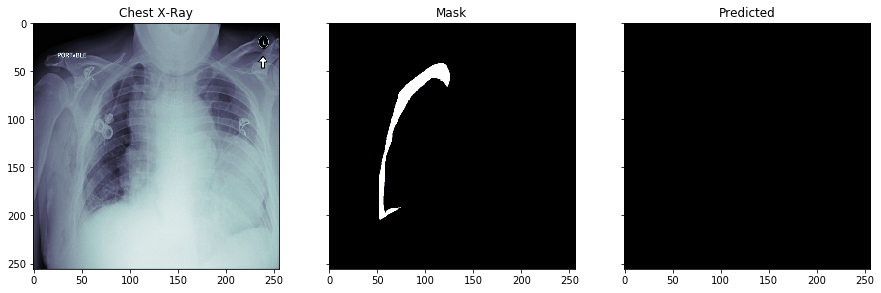

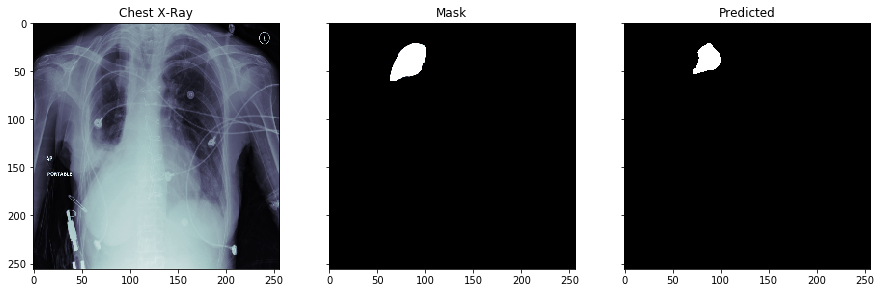

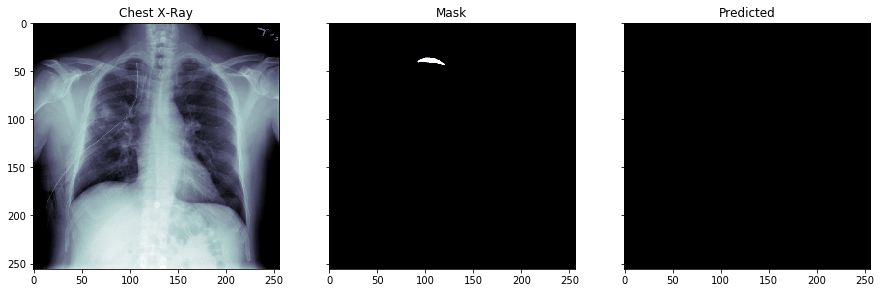

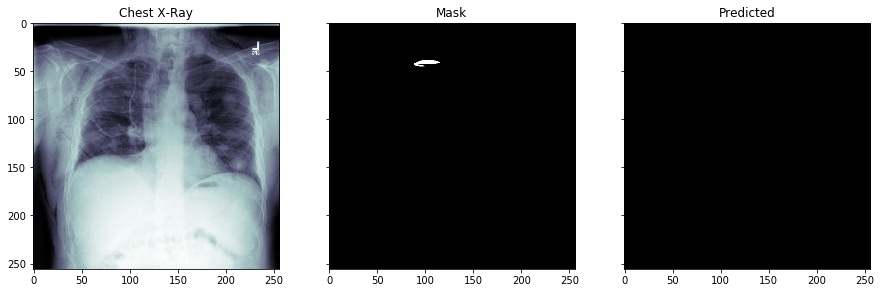

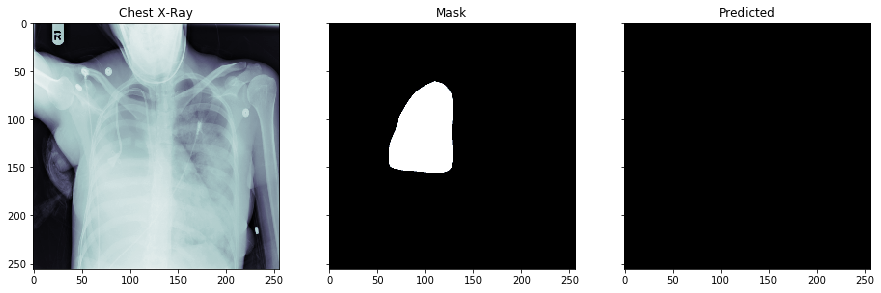

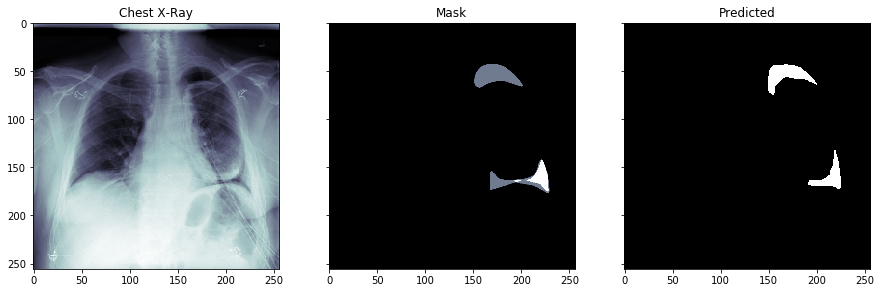

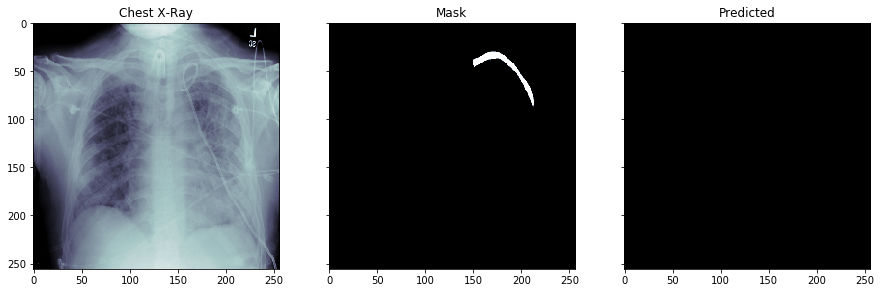

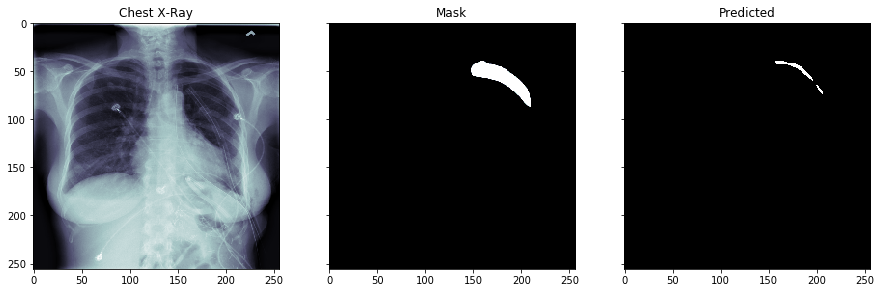

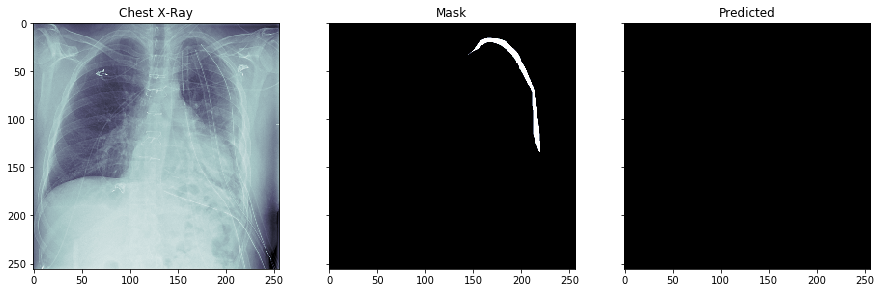

In [30]:
count=0
for i in range(40):
    if count<=15:
        x,y=validation_generator.__getitem__(i)
        predictions=model.predict(x)
        for idx,val in enumerate(x):
            if y[idx].sum()>0 and count<=15:
                img=np.reshape(x[idx]*255,(img_size,img_size))
                mask=np.reshape(y[idx]*255,(img_size,img_size))
                pred=np.reshape(predictions[idx],(img_size,img_size))
                pred=pred>0.5
                pred=pred*255
                plot_train(img,mask,pred,count)
                count+=1

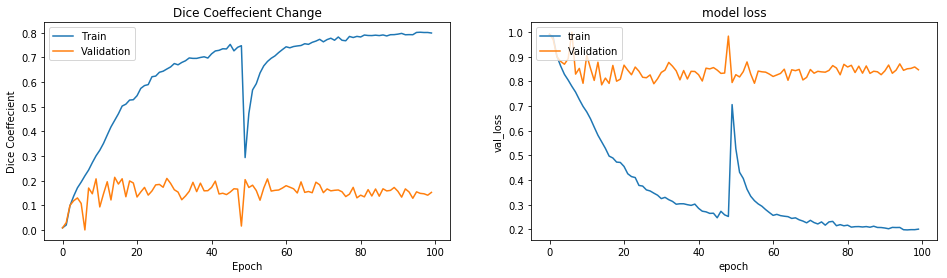

In [31]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(history.history['dice_coeff'])
plt.plot(history.history['val_dice_coeff'])
plt.ylabel('Dice Coeffecient')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.title('Dice Coeffecient Change')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.title('model loss')
plt.savefig('/kaggle/working/plots.png')
plt.show()

In [32]:
from IPython.display import FileLink, FileLinks
FileLinks('.') #lists all downloadable files on server

./
  preds1.png
  preds14.png
  preds0.png
  preds3.png
  preds2.png
  preds13.png
  preds15.png
  preds8.png
  SIIM-ResUNet_100.h5
  preds7.png
  preds10.png
  preds4.png
  plots.png
  preds9.png
  preds12.png
  __notebook__.ipynb
  preds11.png
  preds6.png
  preds5.png
  __output__.json